# Notebook 27: Undecidable Search Problems

In [1]:
#@title Setup
!pip install -qqq tock
from tock import *
!test -x /content/theory || git clone --quiet https://github.com/ND-CSE-30151/spring-2024 /content/theory
%cd -q /content/theory/notes
from IPython.display import IFrame, HTML

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.5/536.5 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


Today we make good on a claim we made on the first day of class: There is no such thing as a computer program that can solve [Post's Correspondence Problem](https://en.wikipedia.org/wiki/Post_correspondence_problem) (which we demonstrated as the game [Poco](https://bit.ly/pocogame)).

Last time, we laid out the following general outline of an undecidability proof, in which we implement a universal decider depicted like this:

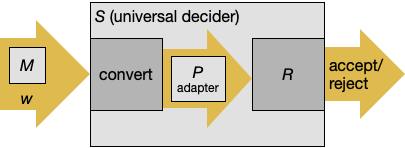

Moreover, we said that the way $P$ usually works is by simulating $M$ on $w$. That works if $P$ is a Turing machine or Python program or some other thing that is as powerful as a Turing machine. But what if $P$ is something simpler, like an instance of PCP?

### Undecidable search problems

<div class="alert alert-info">
    <p><b>Read</b> the subsection "Reductions via Computation Histories" up to Theorem 5.9 and its proof.</p>
</div>    

When you have to prove an undecidability result about a thing more limited than a Turing machine *and* involving a "there exists," a very useful technique for simulating a Turing machine is to use *computation histories*.

Recall that a configuration can be encoded as a string as described on page 168: $uqav$ is the configuration where $u$ is the tape to the left of the head, $q$ is the current state, $a$ is the symbol under the head, and $v$ is the tape to the right of the head.

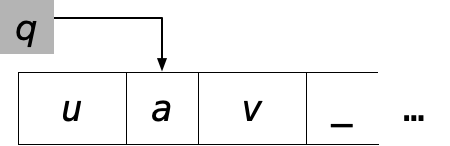

A *computation history* is a sequence of configurations $C_1, C_2, \ldots, C_l$, where $C_1$ is a start configuration and each $C_{i-1}$ yields $C_i$. An accepting computation history is one whose last configuration is an accepting configuration. When encoded as a string, we usually write it as $\# C_1 \# C_2 \# \cdots \# C_l \#$.

For example, using our trusty TM $M_2$ (which recognizes $\{ \texttt{0}^{2^n} \mid n \geq 0 \}$) and input $\texttt{00}$:

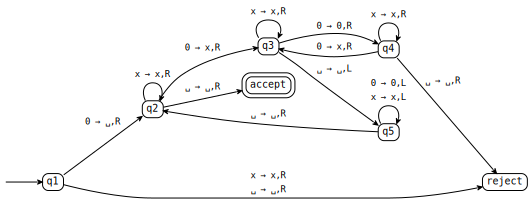

In [ ]:
m2 = read_csv('tm-m2.csv')
m2

In [ ]:
path = run(m2, '0 0').shortest_path()
path

q1,[0] 0
q2,␣ [0]
q3,␣ x [␣]
q5,␣ [x] ␣
q5,[␣] x ␣
q2,␣ [x] ␣
q2,␣ x [␣]
accept,␣ x ␣ [␣]


This is what the computation history looks like, encoded as a string:

In [ ]:
def encode(c):
    """Convert a TM configuration to Sipser's format"""
    q = str(c.stores[0])
    tape = c.stores[1].values
    head = c.stores[1].position
    u = tape[:head]
    a = tape[head]
    v = tape[head+1:]
    return ' '.join(u + (q, a) + v)
computation_history = [encode(c) for c in path]
print('#', ' # '.join(computation_history), '#')

# q1 0 0 # ␣ q2 0 # ␣ x q3 ␣ # ␣ q5 x ␣ # q5 ␣ x ␣ # ␣ q2 x ␣ # ␣ x q2 ␣ # ␣ x ␣ accept ␣ #


The reason computation histories are interesting is that an accepting computation history for $w$ may be easier to recognize than $w$ itself. So even something simpler than a TM, like Post's Correspondence Problem, might be able to encode a TM's computation history.

### LBA emptiness

The book's first example of a proof using computation histories involves *linear bounded automata*, which are just Turing machines where the tape is exactly as long as the input string. For example, if the input string is $\texttt{0110}$, an LBA looks something like:

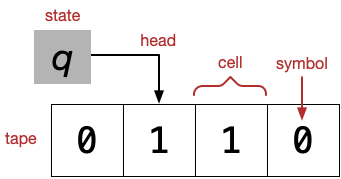

Note that there are no cells after the input string. (LBAs are interesting because nondeterministic LBAs recognize a class of languages, the *context-sensitive languages*, that are another rung on the Chomsky hierarchy that we haven't talked about before. The CSLs are also generated by *context-sensitive grammars*, whose rules are of the form $\alpha B \gamma \rightarrow \alpha \beta \gamma$ where $\alpha$, $\beta$, and $\gamma$ are strings of terminals and nonterminals.)

We want to prove that it is undecidable whether an LBA recognizes the empty language. Up till now, our proofs have tried to implement a universal decider $S$ that takes input $\langle M, w\rangle$ and builds an "adapter" $B$ that somehow involves simulating $M$ on $w$.

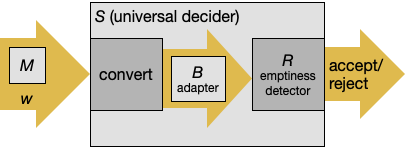

But here our "adapter" has to be an LBA, and an LBA isn't powerful enough to simulate $M$. But, an LBA *is* powerful enough to test whether its input is an accepting computation history for $M$ on $w$. And the emptiness-detector $R$ is able to test whether *there exists* something that $B$ accepts, which means that there exists an accepting computation history for $M$ on $w$, which means that $M$ accepts $w$.

<div class="alert alert-info">
    <p><b>Read</b> the rest of Section 5.1 (pages 223–226).</p>
</div>    

The core of the proof is writing the LBA that checks whether its input is an accepting computation history for $M$ on $w$. It's not too hard to imagine (I think) how a TM could do this without requiring any scratch space beyond the end of the input string.

Then we can implement the universal decider $S =$ "On input $\langle M, w\rangle$":
1. Construct an LBA $B$ that accepts accepting computation histories for $M$ on $w$.
2. Run $R$ on $B$.
3. If $R$ accepts, *reject*; if $R$ rejects, *accept*.

As before, let's think through the various possible outcomes:

- If $M$ accepts $w$, then there exists a computation history for $M$ on $w$, so $B$ recognizes a non-empty language, so $R$ rejects $B$, so $S$ accepts $\langle M,w\rangle$.
- If $M$ rejects or loops on $w$, then there does not exist a computation history for $M$ on $w$, so $B$ recognizes the empty language, so $R$ accepts $B$, so $S$ rejects $\langle M,w\rangle$.

### Post's Correspondence Problem

<div class="alert alert-info">
    <p><b>Read</b> Section 5.2.</p>
</div>    

Recall that an instance of PCP is a set of "dominos", for example

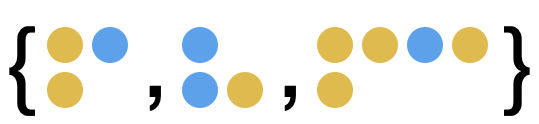

and to solve an instance, you must find a sequence of dominos such that the top row equals the bottom row.

In the first class, we demonstrated a gamified version of PCP called [Poco](https://bit.ly/pocogame).

PCP appears too simple to simulate a Turing machine, but note that solving PCP is a search problem: we want to know whether *there exists* a solution.

To prove that PCP is undecidable, the book introduces a slightly modified version of PCP (MPCP), which has a special domino that the solution must start with. The book proves that MPCP is undecidable by reduction from $A_{\mathsf{TM}}$, then proves that PCP is undecidable by reduction from MPCP.

The proof constructs an MPCP instance $P$ such that $P$ has a solution iff $M$ accepts $w$. The solution must start with the domino in Part 1:
$$ \left[ \frac{\#}{\#q_0 w_1 \cdots w_n \_ \#} \right] $$
After putting down this first domino, the bottom row is longer than the top row. Thereafter (as you can convince yourself by studying the dominos), the top row can never become longer than the bottom row. This property is convenient because it allows us to think of the excess portion of the bottom row as a queue: a domino $\left[ \frac{t}{b} \right]$ can be thought of as "pop $t$ from the left and push $b$ on the right". For example,

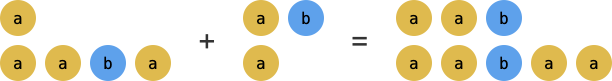

In this picture, the excess is initially $\texttt{aba}$. Adding the domino $\left[ \frac{\texttt{ab}}{\texttt{a}} \right]$ acts like popping $\texttt{ab}$ on the left and pushing $\texttt{a}$ on the right, making the excess $\texttt{aa}$.

With that in mind, perhaps we can interpret the dominos in the construction more easily. The domino in Part 1 (shown above) pushes the start configuration followed by $\#$.

Parts 2–5 work together to pop a configuration and push possible successor configurations. I modified them a little bit:

\begin{align*}
(4,5\text{a}) \qquad &\left[ \frac{a}{a} \right] && \text{for each $a \in \Gamma \cup \{\#\}$} \\
(2) \qquad &\left[ \frac{qa}{br} \right] && \text{for each transition $q \xrightarrow{a \rightarrow b, \text{R}} r$} \\
(2') \qquad &\left[ \frac{qa\#}{br\_\#} \right] && \text{for each transition $q \xrightarrow{a \rightarrow b, \text{R}} r$} \\
(3) \qquad &\left[ \frac{cqa}{rcb} \right] && \text{for each transition $q \xrightarrow{a \rightarrow b, \text{L}} r$ and $c \in \Gamma$} \\
(3') \qquad &\left[ \frac{\#qa}{\#rb} \right] && \text{for each transition $q \xrightarrow{a \rightarrow b, \text{L}} r$}
\end{align*}

Domino (4,5a) just copies symbols that don't change from one configuration to the next. Domino (2) handles move-right rules; (2$'$) handles the case where the head is at the right end of the explored part of the tape. Domino (3) handles move-left rules; (3$'$) handles the case where the head is at the left end of the tape.

Parts 6–7 work together with Part 4,5a to recognize an accepting configuration, and when it is found, to eat it away little by little until there is nothing left, at which point the solution is complete.

\begin{align*}
(6\text{a}) \qquad &\left[ \frac{a q_{\text{accept}}}{q_{\text{accept}}} \right] \\
(6\text{b}) \qquad &\left[ \frac{q_{\text{accept}} a}{q_{\text{accept}}} \right] \\
(7) \qquad &\left[ \frac{q_{\text{accept}} \# \#}{\#} \right] \\
\end{align*}

### Halt

That's it for Unit III of the course! We've seen:

- Turing machines (TMs)
    - What they are
    - How to write them
- Church-Turing thesis
    - TMs define what it means to compute
    - Variants of TMs don't make TMs more powerful
    - TMs can even simulate any TM given to it
- Undecidability
    - Almost all languages are undecidable
    - We can prove this by diagonalizability
    - Or we can prove it by reduction from another undecidable language
    
In the next and final unit, we will explore the *time complexity* of deciding languages using Turing machines, and whether some languages are inherently difficult to decide.